In [1]:
%pip install pandas
%pip install requests
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

url = "https://data.economie.gouv.fr/api/explore/v2.1/catalog/datasets/balances_des_comptes_etat/exports/csv?use_labels=true"

response = requests.get(url)
response.raise_for_status()

data = pd.read_csv(StringIO(response.text), sep=";")


In [4]:
df = data.copy()
df.head(2)

,LibelleMission,Postes,Sous-postes,Indicateurs de synthèse,Indicateurs de détail,Mission,Compte,Nature Budgétaire,Programme,Libellé Ministère,Année,Balance Sortie,Catégorie,Texte 1,Texte 2,Multiplicateur,Balance Sortie 2,Balance sortie en Milliards d'euros
0,Santé,Engagements hors bilan,Dispositifs d'intervention,S805_Dispositifs d'intervention,NaN,MSA,8073400000,NaN,0204,Santé et prévention,2017,-19389620.0,EHB,La mission « Santé » du budget général de l'Ét...,NaN,1,-19389620.0,-0.019
1,"Agriculture, alimentation, forêt et affaires r...",Engagements hors bilan,Dispositifs d'intervention,S805_Dispositifs d'intervention,NaN,MAC,8073400000,NaN,0215,Agriculture et souveraineté alimentaire,2021,0.0,EHB,"La mission « Agriculture, Alimentation, Forêt ...",NaN,1,0.0,0.000


<h1> Exploration des données</h1>

- Dans "Catégorie" nous retrouvons les différentes composantes du bilan et du comptes de résultat (Actif, Passif, Situation Nette, EHB, Charges, Produits..) => Cela nous sera très utile pour les analyses 
- Les comptes **6543100, 6543200 et 6543300** sont considérés comme des Produits et non comme des Charges
- La Catégorie EHB => Comptes de classe 8 sauf compte 8800000 (=> Situation nette)
- La Situation Nette => Comptes de classe 1 (Capitaux Propres) et compte 8800000; Elle fait partie du Passif et devra donc être négative pour arriver à un équilibre avec l'Actif du Bilan. Vu qu'elle est positive dans le dataset (sans doute valeur absolue?), nous devrons multiplier par -1.
- Balance Sortie 2 => Balance Sortie * Multiplicateur (Ces deux colonnes se révèlent donc inutiles en gardant la Balance Sortie 2)
- Résultat => Négatif dans le dataset donc aucun changement à apporter

<h2> Analyse des données</h2>

 - Nous allons analyser dans un premier temps le **Bilan**, puis le **Compte de Résultat** et enfin nous observerons les **dépenses par ministère**

<h1 style = "text-align : center; color : green">Bilan</h1>

In [5]:
# Création d'un DF avec le montant total de la balance en milliards d'€ par catégorie et par année
df_grouped = df.groupby(["Année","Catégorie"])["Balance sortie en Milliards d'euros"].sum()

#Pour revenir à un Dataframe
df_grouped = df_grouped.reset_index()


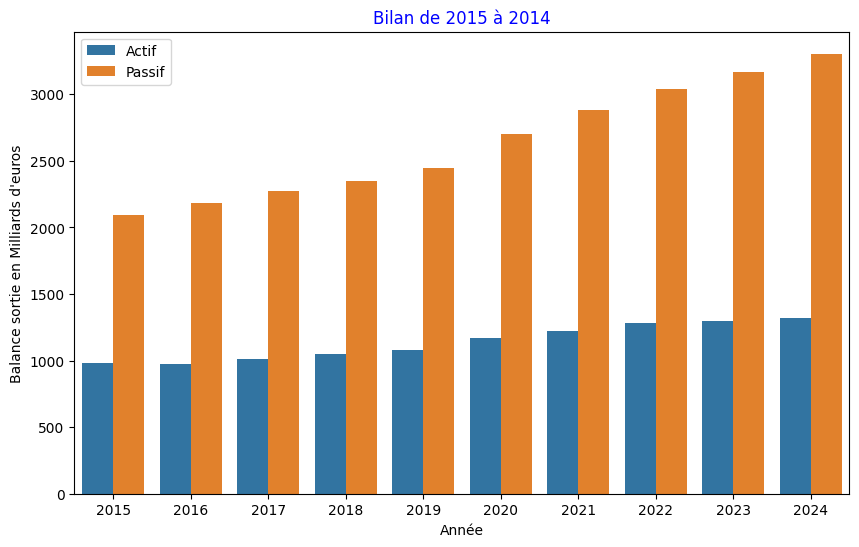

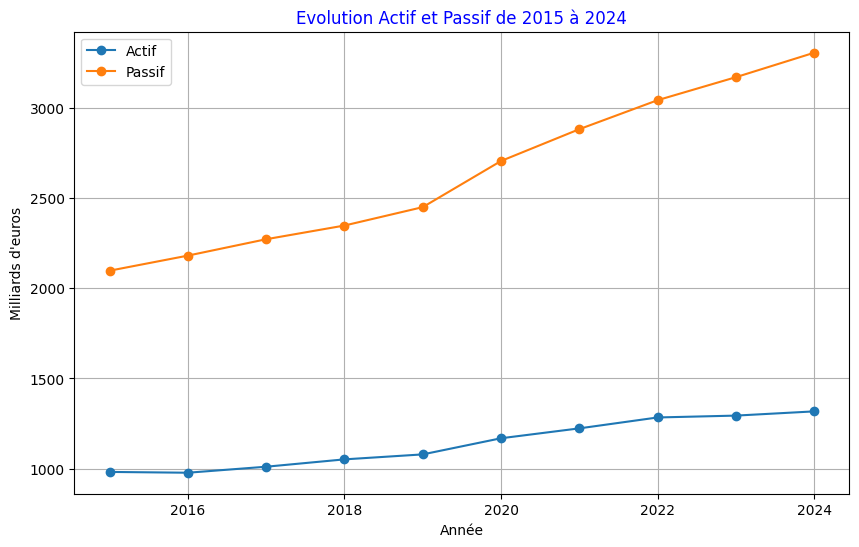

In [6]:
# Nous allons créer un DF juste avec les Catégories Actif et Passif pour observer leur évolution au fil des années à l'aide d'un bar chart

bilan = df_grouped[(df_grouped["Catégorie"] == "Actif") | (df_grouped["Catégorie"] == "Passif")]

plt.figure(figsize=(10,6))
sns.barplot(
    data = bilan,
    x = "Année",
    y = "Balance sortie en Milliards d'euros",
    hue = "Catégorie"
)
plt.title("Bilan de 2015 à 2014", color="blue")
plt.legend()
plt.grid(False)
plt.show()

# Pour observer l'évolution de l'Actif et du Passif sur un autre chart, nous devons les séparer de la colonne Catégorie

a = bilan[bilan["Catégorie"] == "Actif"]
b = bilan[bilan["Catégorie"] == "Passif"]

a = a.rename(columns={"Balance sortie en Milliards d'euros": "balance_actif"})
b = b.rename(columns={"Balance sortie en Milliards d'euros": "balance_passif"})

df_bilan = pd.merge(a, b, on="Année")

plt.figure(figsize=(10,6))
plt.plot(df_bilan['Année'], df_bilan['balance_actif'], marker='o', label='Actif')
plt.plot(df_bilan['Année'], df_bilan['balance_passif'], marker='o', label='Passif')
plt.title("Evolution Actif et Passif de 2015 à 2024", color="blue")
plt.xlabel("Année")
plt.ylabel("Milliards d'euros")
plt.legend()
plt.grid(True)
plt.show()

 - Ces deux graphiques nous montrent le déséquilibre entre l'Actif et le Passif ainsi que leur évolution au fil des années.
 - Augementation de l'Actif et du Passif sur la période. Cependant le Passif augmente plus rapidement que l'Actif avec notamment un pic à partir de 2019

#### Comme le Passif est supérieur à l’Actif, la Situation Nette sera négative tout comme le Résultat

In [8]:
# Dans le dataset, la Situation Nette est positive.. Il s'agit sans doute de la valeur absolue 
# => Nous devons multiplier par -1 pour retrouver une Situation Nette négative

df1 = df_grouped[df_grouped["Catégorie"] == "Situation nette"]
df1["Situation nette actualisée"] = df1["Balance sortie en Milliards d'euros"] * -1
df1

,Année,Catégorie,Balance sortie en Milliards d'euros,Situation nette actualisée
5,2015,Situation nette,1032.600,-1032.600
11,2016,Situation nette,1127.382,-1127.382
17,2017,Situation nette,1199.583,-1199.583
23,2018,Situation nette,1243.827,-1243.827
29,2019,Situation nette,1285.370,-1285.370
35,2020,Situation nette,1370.723,-1370.723
41,2021,Situation nette,1515.648,-1515.648
47,2022,Situation nette,1598.024,-1598.024
53,2023,Situation nette,1750.303,-1750.303
59,2024,Situation nette,1863.619,-1863.619


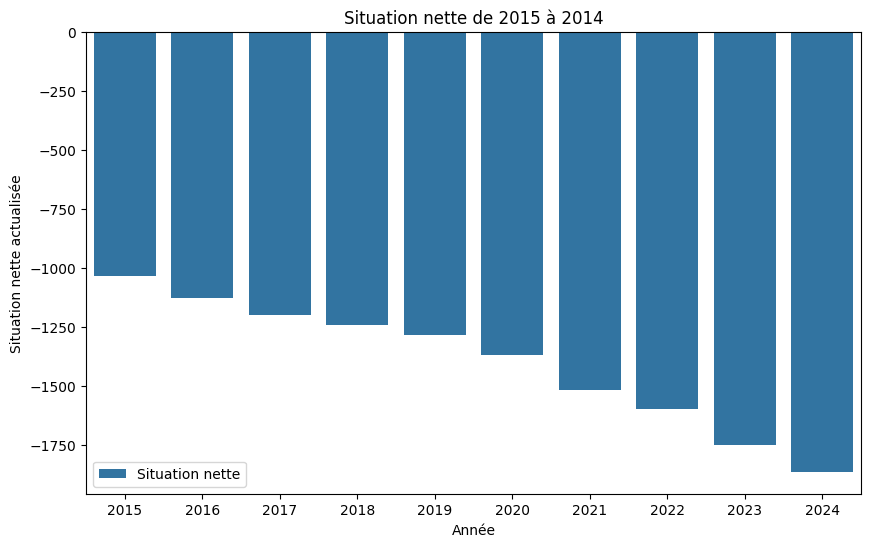

In [9]:
plt.figure(figsize = (10,6))

sns.barplot(
    data = df1,
    x = "Année",
    y = "Situation nette actualisée",
    hue = "Catégorie")

plt.legend()
plt.title("Situation nette de 2015 à 2014")
plt.show()


Dégradation progressive de la situation patrimoniale nette, marquée par une croissance structurellement plus rapide du Passif que de l’Actif

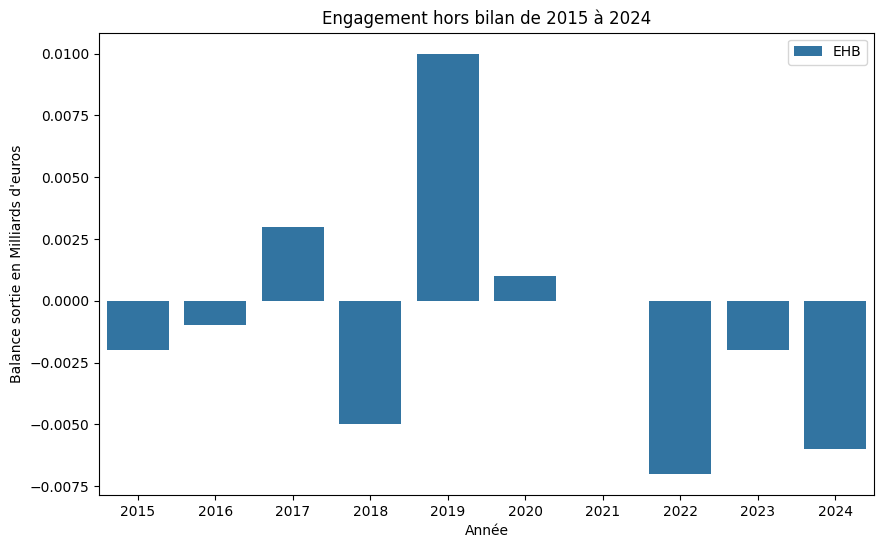

In [22]:
ehb = df_grouped[df_grouped["Catégorie"] == "EHB"]

plt.figure(figsize = (10,6))

sns.barplot(
    data = ehb,
    x = "Année",
    y = "Balance sortie en Milliards d'euros",
    hue = "Catégorie")

plt.legend()
plt.title("Engagement hors bilan de 2015 à 2024")
plt.show()

Les engagements hors bilan, de montants très limités au regard des masses du bilan, ne présentent pas de caractère significatif et n’affectent ni l’analyse du bilan ni celle du résultat sur la période étudiée

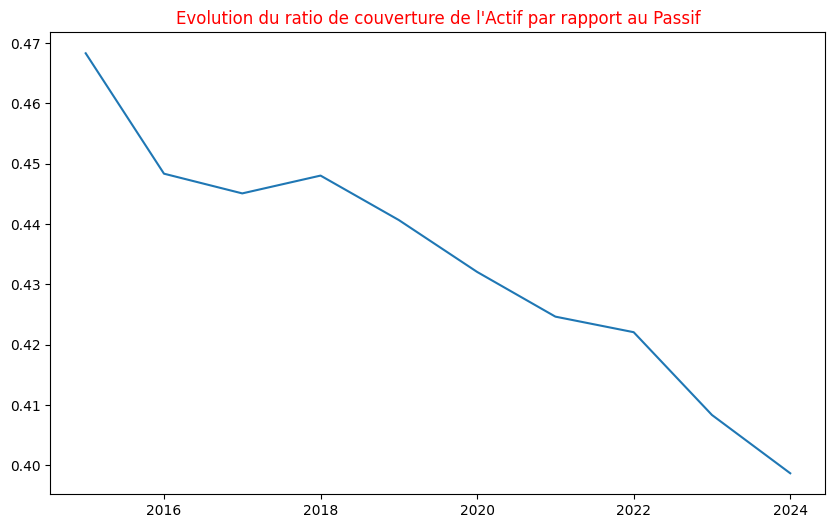

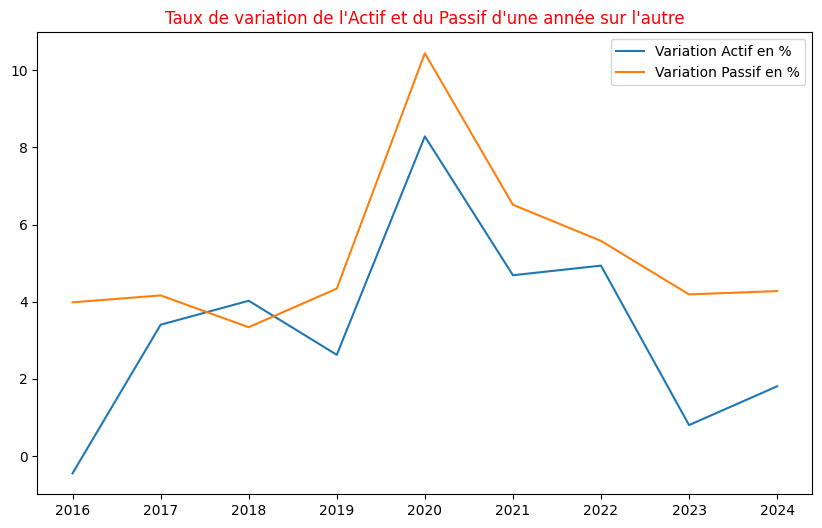

In [12]:
# Calcul du ratio de couverture (Actif / Passif)
df_bilan['Ratio_couverture'] = df_bilan['balance_actif'] / df_bilan['balance_passif']

# Calcul Variation en €
df_bilan['var_actif'] = df_bilan['balance_actif'].diff()
df_bilan['var_passif'] = df_bilan['balance_passif'].diff()

# Variation en %
df_bilan['var_actif_%'] = df_bilan['balance_actif'].pct_change() * 100
df_bilan['var_passif_%'] = df_bilan['balance_passif'].pct_change() * 100

plt.figure(figsize = (10,6))
plt.plot(df_bilan["Année"],df_bilan['Ratio_couverture'], label="Ratio Couverture")
plt.title("Evolution du ratio de couverture de l'Actif par rapport au Passif", color = "red")
plt.show()
plt.figure(figsize = (10,6))
plt.plot(df_bilan["Année"],df_bilan["var_actif_%"], label="Variation Actif en %")
plt.plot(df_bilan["Année"],df_bilan["var_passif_%"], label ="Variation Passif en %")
plt.legend()
plt.title("Taux de variation de l'Actif et du Passif d'une année sur l'autre", color = "red")
plt.show()


 - Entre 2015 et 2024, le bilan de la France se caractérise par une augmentation continue de l’Actif et du Passif, avec une progression systématiquement plus rapide du Passif, entraînant une dégradation régulière du ratio de couverture, qui passe de 0,47 en 2015 à 0,40 en 2024.
 - Le Passif progresse globalement à un rythme supérieur à celui de l’Actif, avec un pic marqué en 2020, puis un ralentissement progressif, tandis que l’Actif connaît une évolution plus irrégulière et un net recul en 2023, ce qui se traduit comptablement par une situation nette négative et de plus en plus déficitaire sur l’ensemble de la période.

<h1 style =" text-align : center; color : green">Compte de Résultat</h1>

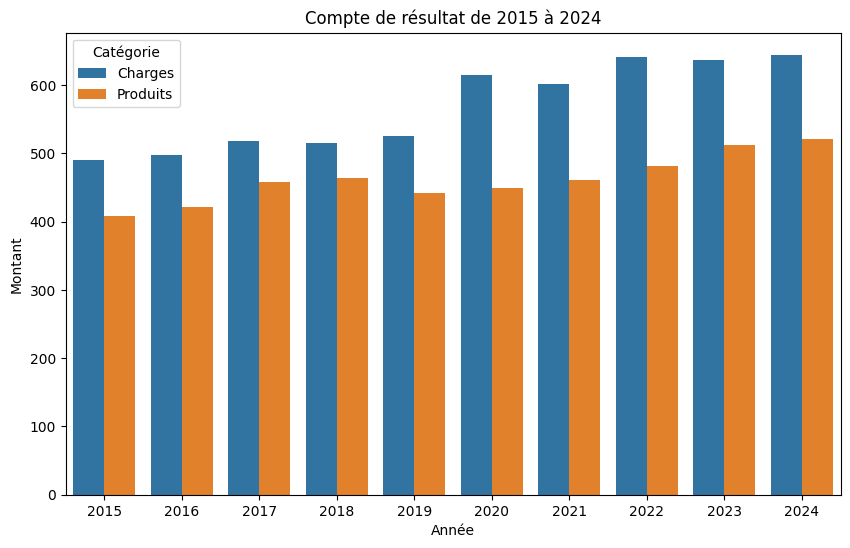

In [13]:
compte_résultat = df_grouped[(df_grouped["Catégorie"] == "Charges") | (df_grouped["Catégorie"] == "Produits")]
compte_résultat

plt.figure(figsize=(10,6))
sns.barplot(
    data = compte_résultat,
    x = "Année",
    y = "Balance sortie en Milliards d'euros",
    hue = "Catégorie"    
)

plt.title("Compte de résultat de 2015 à 2024")
plt.xlabel("Année")
plt.ylabel("Montant")

plt.show()


#### Une première tendance se dégage : 
 - Les Charges sont toujours supérieures aux Produits. Le delta semblait se résorber entre 2014 et 2018 mais à partir de 2019 et surtout en 2020, les charges ont fortement augmentées tandis que les produits sont restés constants voir en légère baisse.

#### Analysons le Résultat Net

In [14]:
# Nous allons isoler les charges et les produits dans deux DF différents pour ensuite les merger dans un seul DF qui nous servira de base de travail
charges = compte_résultat[compte_résultat["Catégorie"] == "Charges"]
produit = compte_résultat[compte_résultat["Catégorie"] == "Produits"]

charges = charges.rename(columns={"Balance sortie en Milliards d'euros": "balance_charges"})
produit = produit.rename(columns={"Balance sortie en Milliards d'euros": "balance_produit"})

df_result = pd.merge(produit, charges, on="Année")


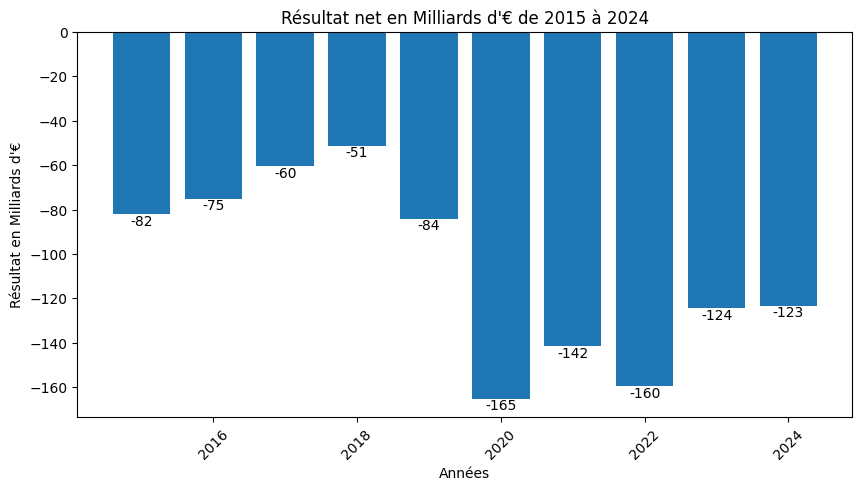

In [15]:
# Maintenant que nous avons une colonne pour les charges et une pour les produits nous pouvons faire la soustraction pour obtenir notre résultat net

df_result["résultat"] = df_result["balance_produit"] - df_result["balance_charges"]

plt.figure(figsize=(10,5))

bars = plt.bar(df_result["Année"], df_result["résultat"])

plt.title("Résultat net en Milliards d'€ de 2015 à 2024")
plt.xlabel("Années")
plt.ylabel("Résultat en Milliards d'€")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,.0f}",
        ha="center",
        va="top"
    )
plt.show()

#### Deux constats : 
 - Une amélioration du résultat entre 2015 et 2018 (dûe à une augmentation des produits plus conséquente que l'augmentation des charges)
 - Une dégradation du résultat à partir de 2019 et jusqu'en 2024 (Liée à la forte augmentation des charges constatée en 2020 par rapport à l'augmentation des produits qui elle est restée plus ou moins constante sur la même période)

#### Analysons l'évolution des Charges et Produits ainsi que leur ratio de couverture et leur taux de variation d'une année sur l'autre

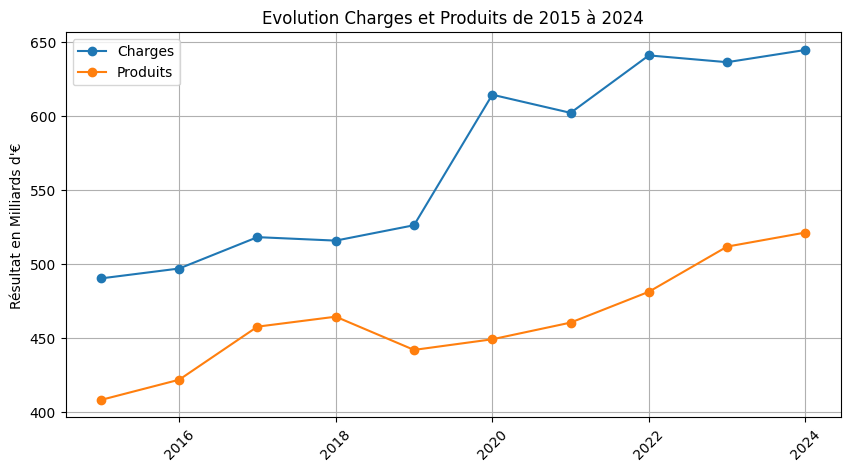

In [16]:
# Graphique de l'évolution des Charges et Produits

plt.figure(figsize=(10, 5))
plt.plot(df_result["Année"], df_result["balance_charges"], marker = "o",label = "Charges")
plt.plot(df_result["Année"], df_result["balance_produit"], marker = "o", label = "Produits")
plt.title("Evolution Charges et Produits de 2015 à 2024")
plt.ylabel("Résultat en Milliards d'€")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()



Les charges connaissent des pics plus importants que les produits à certaines années, accentuant le déficit

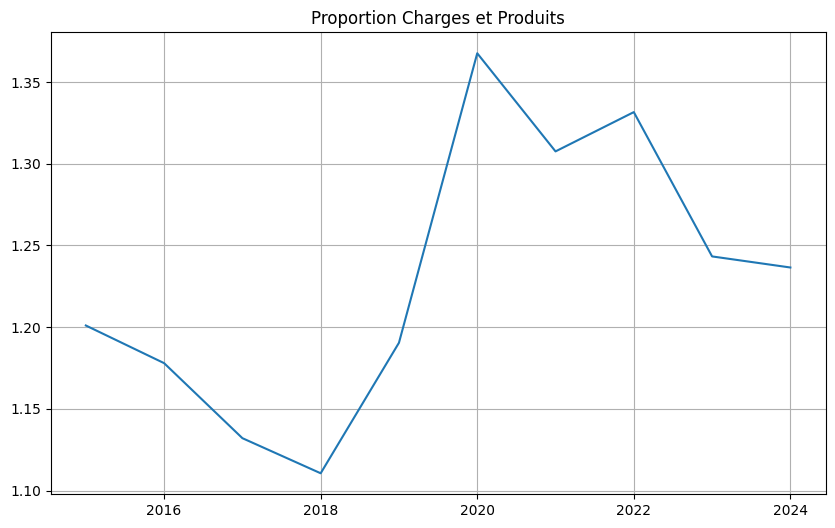

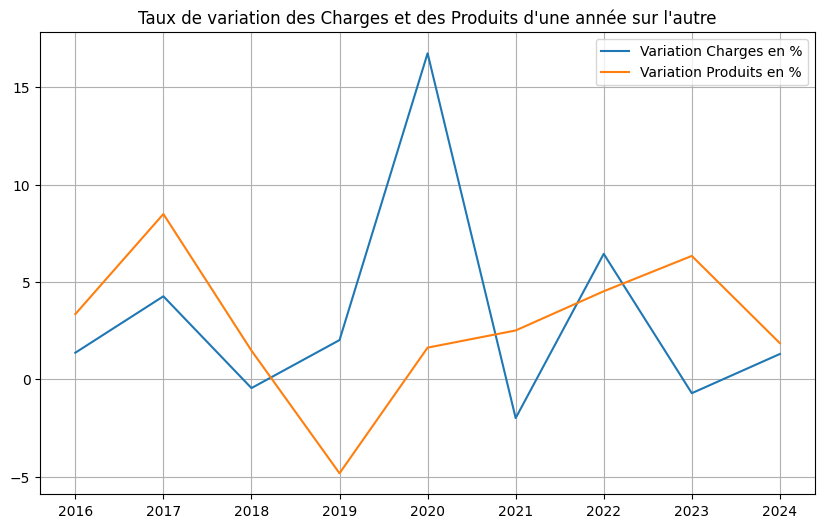

In [17]:
# Proportion des charges par rapport aux produits
df_result["proportion_charges"] = df_result["balance_charges"] / df_result["balance_produit"]

# Calcul Variation en €
df_result['var_charges'] = df_result['balance_charges'].diff()
df_result['var_produit'] = df_result['balance_produit'].diff()

# Variation en %
df_result['var_charges_%'] = df_result['balance_charges'].pct_change() * 100
df_result['var_produit_%'] = df_result['balance_produit'].pct_change() * 100

# Graphique Couverture
plt.figure(figsize = (10,6))
plt.plot(df_result["Année"],df_result['proportion_charges'], label = "Proportion des Charges par rapport aux Produits")
plt.title("Proportion Charges et Produits")
plt.grid(True)
plt.show()

# Graphique Variation en %
plt.figure(figsize = (10,6))
plt.plot(df_result["Année"],df_result["var_charges_%"], label="Variation Charges en %")
plt.plot(df_result["Année"],df_result["var_produit_%"], label ="Variation Produits en %")
plt.legend()
plt.grid(True)
plt.title("Taux de variation des Charges et des Produits d'une année sur l'autre")
plt.show()


 - La proportion des Charges par rapport aux Produits est toujours supérieur à 1, confirmant une situation déficitaire continue
 - Les Charges augmentent plus vite et plus fortement que les Produits; En comparant avec le graphique du résultat, on observe que les phases d’amélioration du résultat correspondent davantage à un ralentissement des charges qu’à une forte hausse des produits

<h3 style = "text-align: center; color: green">Analyse des Ministères</h3>

#### Maintenant observons les différents ministères pour voir si certains se détachent par rapport à d'autres

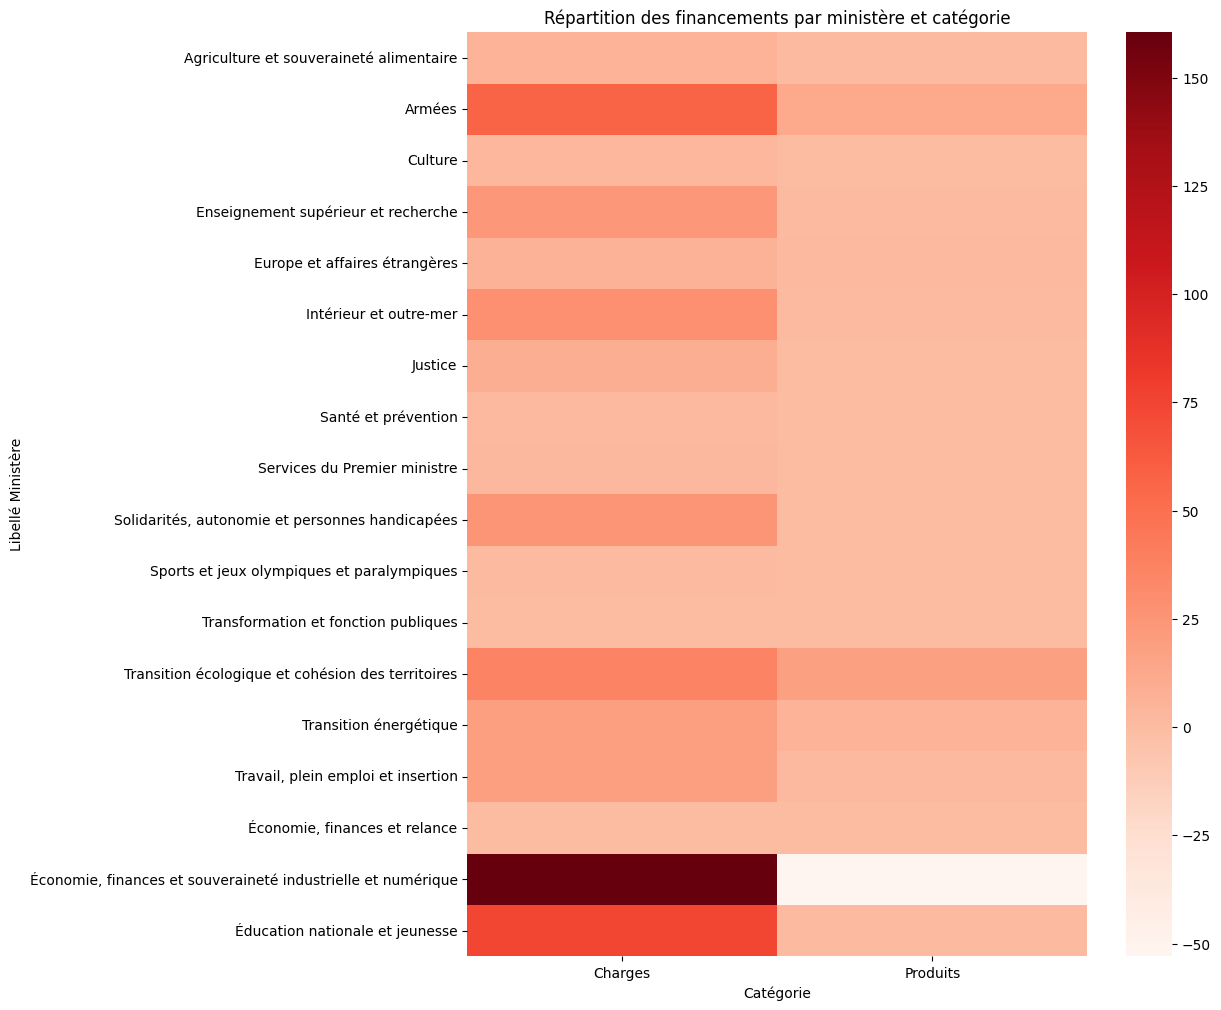

In [10]:
# Nous allons créer un nouveau DF en les regroupant cette fois ci par ministère

df_grouped1 = df.groupby(["Libellé Ministère","Année", "Catégorie"])["Balance sortie en Milliards d'euros"].sum()

#Pour revenir à un Dataframe
df_grouped1 = df_grouped1.reset_index()

#Création d'un heatmap pour avoir une vision globale par ministère et par catégorie

résultat_ministère= df_grouped1[(df_grouped1["Catégorie"] == "Charges") | (df_grouped1["Catégorie"] == "Produits")]
résultat_ministère

pivot = résultat_ministère.pivot_table(
    index="Libellé Ministère",
    columns="Catégorie",
    values="Balance sortie en Milliards d'euros"
).fillna(0)

plt.figure(figsize=(10, 12))
sns.heatmap(pivot, cmap="Reds")
plt.title("Répartition des financements par ministère et catégorie")
plt.show()


 - Les 3 ministères dont les depénses sont les plus importantes sur les 10 dernières années sont "Économie, finances et souveraineté industrielle et numérique", "Éducation nationale et jeunesse" et "Armées"

Visualisons leurs évolutions par année sur un nuage de point

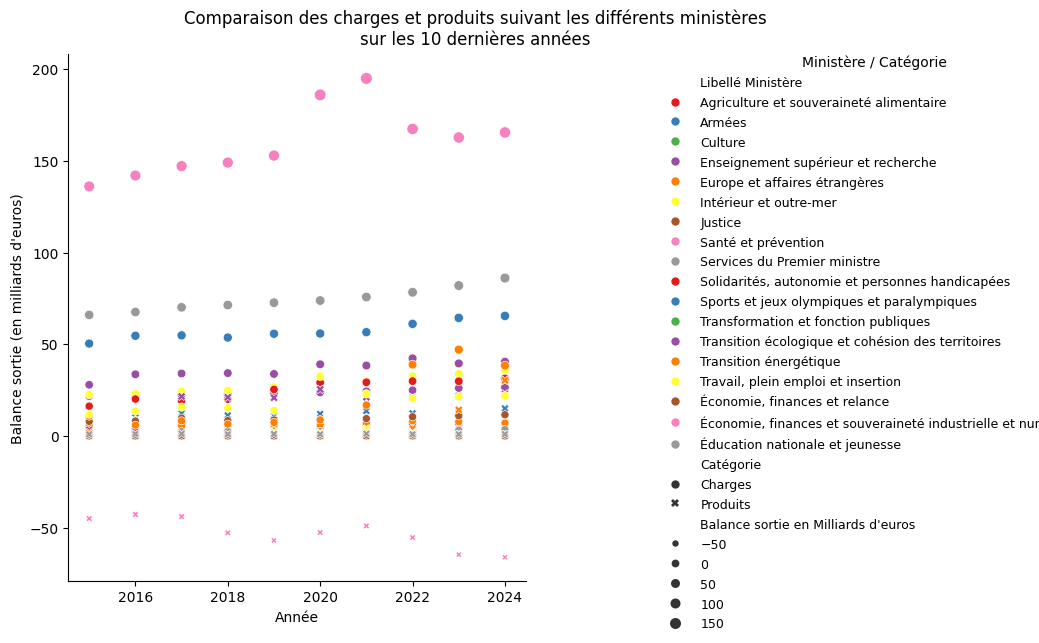

In [11]:
g = sns.relplot(
    x="Année",
    y="Balance sortie en Milliards d'euros",
    data=résultat_ministère,
    hue="Libellé Ministère",
    style="Catégorie",
    size="Balance sortie en Milliards d'euros",
    palette="Set1",
    height=6
)

# Titre principal + marge
g.fig.suptitle(
    "Comparaison des charges et produits suivant les différents ministères\nsur les 10 dernières années",
    fontsize=12,
    y=1.05
)

# Labels des axes
g.set_axis_labels("Année", "Balance sortie (en milliards d'euros)")

# Réduction de la légende
g._legend.set_title("Ministère / Catégorie")
g._legend.set_bbox_to_anchor((1.02, 0.5))  # légende à droite
g._legend.set_frame_on(False)              # enlève le cadre
for text in g._legend.texts:
    text.set_fontsize(9)

plt.show()


 - Les 3 ministères  dont les depénses sont les plus importantes évoluent de manière similaire.
 - L'importante hausse des charges de 2020 constatée sur les graphiques précédents, se retrouve également sur le minitère de l'économie, finance et souveraineté industrielle et numérique.